# Code Parsing

In [2]:
from utils.stringutils import compute_nested_levels, linewise_tokenize, wordwise_tokenize

code = """
def foo(){
    def bar() {
        print
    }
    bar
}
"""
tokens = linewise_tokenize(code)
print(tokens)
levels = compute_nested_levels(tokens, indent_is_relevant=False)
print(levels)

['\n', 'def foo(){\n', '    def bar() {\n', '        print\n', '    }\n', '    bar\n', '}\n']
[0, 1, 2, 2, 1, 1, 0]


In [3]:
def compute_derivative_array(list):
    '''list is a list of numbers that ascend and descend.'''
    derivative = [0]
    for i in range(1, len(list) - 1):
        derivative.append(list[i+1] - list[i-1])
    derivative.append(0)
    return derivative

compute_derivative_array(levels)

[0, 2, 1, -1, -1, -1, 0]

In [4]:
from utils.stringutils import wordwise_tokenize, linewise_tokenize

line = "    final coded = events.map((e) => e.toJson()).toList();"
tokens = wordwise_tokenize(line)
print(tokens)

['    ', 'final', ' ', 'coded', ' ', '=', ' ', 'events', '.', 'map', '((', 'e', ')', ' ', '=>', ' ', 'e', '.', 'toJson', '()).', 'toList', '();']


# Code Lookup

In [5]:
from utils.stringutils import linewise_tokenize, wordwise_tokenize, edit_distance

In [6]:
database = """
def flat_assignment():
arr = np.empty((3,), dtype=dtype)
values = np.array([value, value, value])
arr.flat[:] = values
yield flat_assignment
@pytest.mark.skipif(IS_WASM, reason="no wasm fp exception support")
@pytest.mark.parametrize(["value", "dtype"], values_and_dtypes())
@pytest.mark.filterwarnings("ignore::numpy.exceptions.ComplexWarning")
def test_floatingpoint_errors_casting(dtype, value):
dtype = np.dtype(dtype)
for operation in check_operations(dtype, value):
dtype = np.dtype(dtype)
match = "invalid" if dtype.kind in 'iu' else "overflow"
with pytest.warns(RuntimeWarning, match=match):
operation()
with np.errstate(all="raise"):
with pytest.raises(FloatingPointError, match=match):
operation()
"""

In [7]:
import numpy as np
from collections import defaultdict
from utils.stringutils import edit_distance
from matplotlib import pyplot as plt

def score(a, b):
    max_len = max(len(''.join(a)), len(''.join(b)))
    if max_len == 0: return 1
    diff = edit_distance(a, b)
    return 1 - (diff / max_len)

def weighted_score(a, b):
    return score(a, b) * np.mean([len(a), len(b)])

db_kmers_cache = {}

def ktuple_matching(query, database, k, part_processing=None):
    global db_kmers_cache
    if not part_processing:
        part_processing = lambda x: x
    if (''.join(database), k) in db_kmers_cache:
        database_kmers = db_kmers_cache[(''.join(database), k)]
    else:
        database_kmers = defaultdict(list)
        for i in range(len(database) - k + 1):
            kmer = ''.join(part_processing(part) for part in database[i:i+k])
            if ''.join(kmer) ==  '': continue
            database_kmers[kmer].append(i)
        db_kmers_cache[(''.join(database), k)] = database_kmers
    
    matches = []
    for i in range(len(query) - k + 1):
        kmer = ''.join(part_processing(part) for part in query[i:i+k])
        if ''.join(kmer) == '': continue
        if kmer in database_kmers:
            for db_pos in database_kmers[kmer]:
                matches.append((i, db_pos))
    return matches

def find_top_diagonal(matches, query, database, k):
    diagonal_scores = defaultdict(int)
    for q_pos, db_pos in matches:
        diag = q_pos - db_pos
        diagonal_scores[diag] += np.mean([weighted_score(q, db) for q, db in zip(query[q_pos:q_pos+k], database[db_pos:db_pos+k])])
    top_diagonal = max(diagonal_scores.items(), key=lambda item: item[1], default=(None, 0))
    return top_diagonal[0]

def smith_waterman_diagonal(
        query,
        database,
        match_score=3,
        mismatch_penalty=3,
        gap_penalty=2,
        processing=None,
        tolerance=0.8,
        diag=0,
        band_width=5,
        db_token_depth_roc=None,
        query_token_depth_roc=None
    ):
    m, n = len(query), len(database)
    
    scoring_matrix, traceback_matrix = defaultdict(int), defaultdict(int)
    if diag >= 0:
        start_row = 1
        start_col = -diag
    else:
        start_row = diag
        start_col = 1

    max_score = 0
    max_pos = (0, 0)
    covered = []
    while start_row <= m and start_col <= n:
        for offset in range(-band_width, band_width + 1):
            row, col = start_row, start_col + offset
            if not (0 < row <= m and 0 < col <= n): continue
            q, d = query[row-1], database[col-1]
            covered.append((row - 1, col - 1))
            if processing:
                q, d = processing(q), processing(d)
            multiplier = 1 + np.mean([len(q), len(d)]) / 2
            match = scoring_matrix[(row-1, col-1)] + (match_score if score(q, d) >= tolerance else -mismatch_penalty) * multiplier
            insert = scoring_matrix[(row, col-1)] - gap_penalty * multiplier
            scoring_matrix[(row, col)] = max(match, insert)

            if scoring_matrix[(row, col)] == match:
                traceback_matrix[(row, col)] = 1
            elif scoring_matrix[(row, col)] == insert:
                traceback_matrix[(row, col)] = 3
            
            if scoring_matrix[(row, col)] >= max_score:
                max_score = scoring_matrix[(row, col)]
                max_pos = (row, col)
        start_row += 1
        start_col += 1

    # Traceback to get the optimal alignment
    align1, align2 = [], []
    i, j = max_pos
    while scoring_matrix[(i, j)] > 0:
        q, d = query[i - 1], database[j - 1]
        if traceback_matrix[(i, j)] == 1:
            align1.insert(0, q)
            align2.insert(0, d)
            i -= 1
            j -= 1
        elif traceback_matrix[(i, j)] == 3:
            align2.insert(0, d)
            align1.insert(0, '-')
            j -= 1
    return align2, max_score, covered

def fasta_algorithm(database, query, k=4, n=3, band_width=5, match_score=3, mismatch_penalty=3, gap_penalty=1, match_processing=None, dp_processing=None, db_token_depth_roc=None, query_token_depth_roc=None, debug=False):
    matches = ktuple_matching(query, database, k, match_processing)
    if debug:
        matrix = np.zeros((len(query), len(database)))
        for q, d in matches:
            matrix[q, d] = 1
        plt.imshow(matrix, cmap='hot', interpolation='nearest')
        plt.show()
    top_diagonal = find_top_diagonal(matches, query, database, k)
    if top_diagonal is None: return None, float('-inf')
    best_alignment, best_score, covered = smith_waterman_diagonal(
        query,
        database,
        match_score=match_score,
        mismatch_penalty=mismatch_penalty,
        gap_penalty=gap_penalty,
        processing=dp_processing,
        diag=top_diagonal,
        band_width=band_width,
        db_token_depth_roc=db_token_depth_roc,
        query_token_depth_roc=query_token_depth_roc
    )
    if debug:
        matrix = np.zeros((len(query), len(database)))
        for q, d in covered:
            matrix[q, d] = 1
        plt.imshow(matrix, cmap='hot', interpolation='nearest')
        plt.show()
    if best_alignment is None:
        return None, float('-inf')
    return best_alignment, best_score

In [8]:
query = """ def test_floatingpoint_errors_casting(dtype, value):
     dtype = np.dtype(dtype)
     for operation in check_operations(dtype, value):
         dtype = np.dtype(dtype)
         match = "invalid" if dtype.kind in 'iu' else "overflow"
         with pytest.warns(RuntimeWarning, match=match):"""

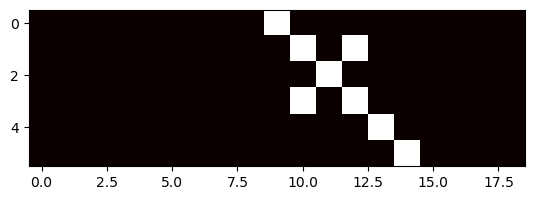

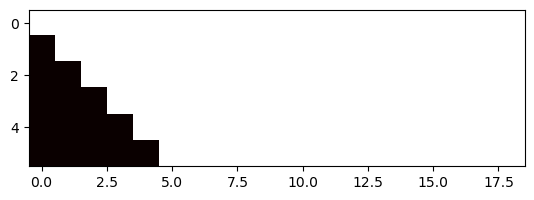

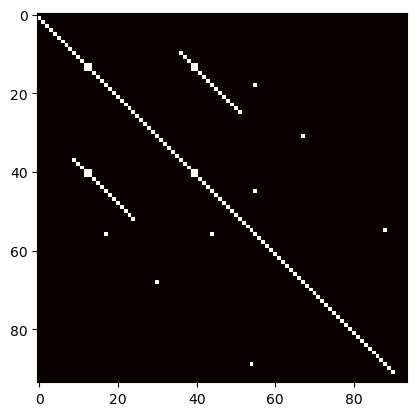

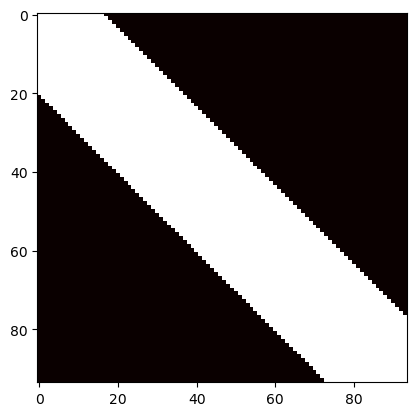

Closest substring in database to query:
 def test_floatingpoint_errors_casting(dtype, value):
dtype = np.dtype(dtype)
for operation in check_operations(dtype, value):
dtype = np.dtype(dtype)
match = "invalid" if dtype.kind in 'iu' else "overflow"
with pytest.warns(RuntimeWarning, match=match):
0.8694158075601375
347


In [9]:
def fuzzy_find(query, database, debug=False):
    # 1. First pass with linewise tokenization
    linewise_tokenized_database = linewise_tokenize(database)
    linewise_tokenized_query = linewise_tokenize(query)

    result, score = fasta_algorithm(
        linewise_tokenized_database,
        linewise_tokenized_query,
        k=1,
        n=1,
        band_width=10,
        match_score=3,
        mismatch_penalty=0.7,
        gap_penalty=0.1,
        match_processing=lambda x: x.strip().replace(' ', ''),
        dp_processing=lambda x: wordwise_tokenize(x.strip().replace(' ', '')),
        debug=debug
    )

    # 2. Second pass with wordwise tokenization
    worwise_tokenized_database = wordwise_tokenize(''.join(result)) if result is not None else wordwise_tokenize(database)
    wordwise_tokenized_query = wordwise_tokenize(query)

    result, score = fasta_algorithm(
        worwise_tokenized_database,
        wordwise_tokenized_query,
        k=max(1, min(3, len(wordwise_tokenized_query) - 1, len(worwise_tokenized_database) - 1)),
        n=1,
        band_width=18,
        match_score=5,
        mismatch_penalty=0.6,
        gap_penalty=0.3,
        match_processing=lambda x: x.strip(),
        dp_processing=lambda x: x.strip(),
        debug=debug
    )

    if result is None:
        return None, float('-inf')
    return ''.join(result), score

# Example usage:
result, _ = fuzzy_find(query, database, debug=True)
print("Closest substring in database to query:\n", result)
print(score(result, query))
print(database.find(result))

In [10]:
diff = """ with pytest.warns(RuntimeWarning, match=match):
 operation()
 with np.errstate(all="raise"):
-    with pytest.raises(FloatingPointError, match=match):
+    with pytest.raises(FloatingPointError, match="foo"):
         operation()"""

In [11]:
def parse_diff(diff_string):
    lines = diff_string.splitlines(keepends=True)
    groups = []
    current_group = []
    in_edit = False

    for line in lines:
        if line.startswith('+') or line.startswith('-'):
            if not in_edit and current_group:
                groups.append(current_group)
                current_group = []
            current_group.append(line)
            in_edit = True
        else:
            if in_edit and current_group:
                groups.append(current_group)
                current_group = []
            current_group.append(line)
            in_edit = False
    
    if current_group:
        groups.append(current_group)
    
    merged_groups = []
    for group in groups:
        if not (group[0].startswith('+') or group[0].startswith('-')):
            merged_groups.append('\n'.join(group))
        else:
            delete, insert = '', ''
            for line in group:
                if line.startswith('-'):
                    delete += line[1:] + '\n'
                elif line.startswith('+'):
                    insert += line[1:] + '\n'
            merged_groups.append((delete, insert))

    return merged_groups

In [12]:
import numpy as np
import re

def skwonk(database: str, diff: str):
    hunks = re.split(r"@@.*?@@", diff)
    i = 0
    for hunk in hunks:
        original = ''.join([line for line in hunk.splitlines(keepends=True) if not line.startswith('+')])
        # 1. Zone in on the string we are going to be editing
        zone, _ = fuzzy_find(original, database[i:])
        i = database.find(zone) + len(zone)
        original_zone = zone

        if zone is None:
            print("No similar substring found in database")
            return database
        
        # 2. Parse the diff into groups
        diff_groups = parse_diff(hunk)
        # 3. Find and replace
        for i in range(len(diff_groups)):
            group = diff_groups[i]
            if not isinstance(group, tuple): continue
            find, replace = group
            if find == '':
                # Insertion
                prior_context = fuzzy_find(diff_groups[i - 1], zone)[0] if i > 0 else None
                further_context = fuzzy_find(diff_groups[i + 1], zone)[0] if i < len(diff_groups) - 1 else None
                insertion_index = zone.find(prior_context) + len(prior_context) if prior_context else None
                if not insertion_index:
                    insertion_index = zone.find(further_context) if further_context else 0
                print(f"Inserting {replace} at index {insertion_index}")
                zone = zone[:insertion_index] + replace + zone[insertion_index:]
            else:
                # Fuzzy find and replace
                fuzz, _ = fuzzy_find(find, zone)
                if fuzz is None: continue
                zone = zone.replace(fuzz, replace, 1)
        database = database.replace(original_zone, zone, 1)
    return database

In [13]:
import difflib
new_database = skwonk(database, diff)
print(new_database)


def flat_assignment():
arr = np.empty((3,), dtype=dtype)
values = np.array([value, value, value])
arr.flat[:] = values
yield flat_assignment
@pytest.mark.skipif(IS_WASM, reason="no wasm fp exception support")
@pytest.mark.parametrize(["value", "dtype"], values_and_dtypes())
@pytest.mark.filterwarnings("ignore::numpy.exceptions.ComplexWarning")
def test_floatingpoint_errors_casting(dtype, value):
dtype = np.dtype(dtype)
for operation in check_operations(dtype, value):
dtype = np.dtype(dtype)
match = "invalid" if dtype.kind in 'iu' else "overflow"
with pytest.warns(RuntimeWarning, match=match):
operation()
with np.errstate(all="raise"):    with pytest.raises(FloatingPointError, match="foo"):

match):
operation()



### Skwonk Algorithm Analysis

In [14]:
import time, random, tqdm, numpy as np
import difflib

def analyze_skwonk(start_length=0, stop_length=2000, step_length=1, batch_length=35, corpus=database):
    times = []
    accuracies = []
    for length in tqdm.tqdm(range(start_length, stop_length, step_length)):
        sub_times = []
        sub_accuracies = []
        for _ in range(batch_length):
            start = random.randint(1, len(corpus.splitlines(keepends=True)) - length)
            substring_og = ''.join(corpus.splitlines(keepends=True)[start:start+length])
            obfuscated_substring = substring_og
            # obfuscate 1% of the characters
            obfuscation_rate = 0.01
            obfuscated_substring = ''.join([c if random.random() > obfuscation_rate else ' ' for c in obfuscated_substring])
            start_time = time.time()
            best_match, best_score = fuzzy_find(obfuscated_substring, corpus)
            if not best_match: continue
            sub_times.append(time.time() - start_time)
            sub_accuracies.append(difflib.SequenceMatcher(None, substring_og, best_match).ratio())
        if len(sub_times) != 0 and len(sub_accuracies) != 0:
            times.append(np.mean(sub_times))
            accuracies.append(np.mean(sub_accuracies))
    return times, accuracies

In [17]:
from matplotlib import pyplot as plt

times, accuracies = analyze_skwonk(start_length=50, stop_length=100, step_length=2, batch_length=30)
plt.plot(times)
plt.xlabel("Length of Substring")
plt.ylabel("Time (s)")
plt.show()
plt.plot(accuracies)
plt.xlabel("Length of Substring")
plt.ylabel("Accuracy")
plt.show()

  0%|          | 0/25 [00:00<?, ?it/s]


ValueError: empty range in randrange(1, -30)